# Performance and code portable vectorization with OpenCL

Change the following to run the same analysis on a different problem size:

In [111]:
%env OCLGRIND=/oclgrind
%env PROBLEM_SIZE=tiny
# %env PROBLEM_SIZE=small
# %env PROBLEM_SIZE=medium
# %env PROBLEM_SIZE=large

# set-up compulsory stuff
%load_ext rpy2.ipython

env: OCLGRIND=/oclgrind
env: PROBLEM_SIZE=tiny
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Vectorization of Mandelbrot Set -- Example 5-33 from Intel 64 and IA-32 Architectures Optimization Reference Manual

This example examines the ability to improve the performance of CPU devices by using vectorisation / Single Instruction Multiple Data (SIMD) level optimization. This is done by first examining the code to produce a Mandelbrot set -- a sample is shown in Figure 1.

<img src="mandelbrot.png" width="200" alt="Figure 1. Mandelbrot set">

<!--
![Figure 1. Mandelbrot set](mandelbrot.png =250x)
-->

The optimization involves restucturing the code to pack four floating point values into the same register allowing 128 bits to be treated in the same instruction. The Intel codebook, from which this example was based, originally targeted SSEv4. However, since this is intel specific an OpenCL alternative was developed. Support for vectorization comes built into OpenCL using vector primatives. 

## Generate runtime data

Run the experiment and collect runtime data

In [100]:
! make clean; make
! ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 1 0 runtime

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_vectorization< writing to >lsb.cpu_vectorization.r0< *****
Attempting kernel: ./cpu-mandelbrot-vectorization-set-map.cl with contents:
//Example 5-32 Baseline C Code for Mandelbrot Set Map Evaluation from:https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf

//#define DIMX (64)
//#define DIMY (64)
//#define X_STEP (0.5f/DIMX)
//#define Y_STEP (0.4f/(DIMY/2))
__kernel void mandelbrot(__global int* map)
{
    int i,j;
    float x = -1.8f;
    for (i=

## Analyse runtime data

In [101]:
import pandas as pd
x = pd.read_csv('lsb.cpu_vectorization.r0', comment='#', sep="\s+")

y = x[(x.region == 'mandelbrot_kernel') | (x.region == 'mandelbrot_vectorized_kernel')]



The distributions of 100 runtimes for each of the 2 kernels is shown below.

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


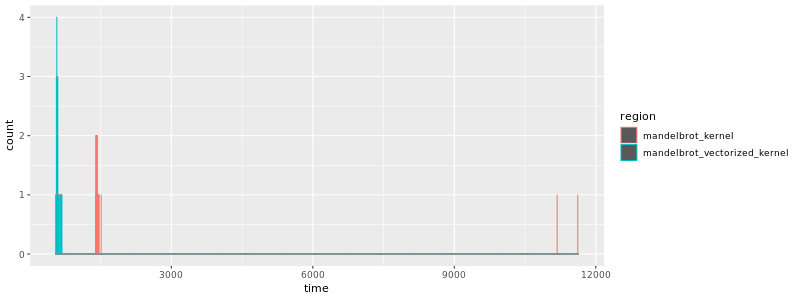

In [102]:
%%R -i y -w 800 -h 300 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.1)
print(pp)

In [104]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).median()

## Generate AIWC feature-space per kernel

In [112]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./cpu-mandelbrot-vectorization ./cpu-mandelbrot-vectorization-set-map.cl $PROBLEM_SIZE 0 0 aiwc
! rm -f lsb.*.r0* #we aren't interested in runtime data anymore

rm -f sbd aiwc-tester lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf cpu-loop-block cpu-mandelbrot-vectorization
g++ cpu-loop-blocking.cpp -o cpu-loop-block -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ cpu-mandelbrot-vectorization.cpp -o cpu-mandelbrot-vectorization -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
g++ aiwc-tester.cpp -o aiwc-tester -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >cpu_vectorization< writing to >lsb.cpu_vectorization.r0< *****
Attempting kernel: ./cpu-mandelbrot-vectorization-set-map.cl with contents:
//Example 5-32 Baseline C Code for Mandelbrot Set Map Evaluation from:https://www.intel.com/content/dam/www/public/us/en/documents/manuals/64-ia-32-architectures-optimization-manual.pdf

//#define DIMX (64)
//#define DIMY (64)
//#define X_STEP (0.5f/DIMX)
//#define Y_STEP (0.4f/(DIMY/2))
__kernel void mandelbrot(__global int* map)
{
    int i,j;
    float x = -1.8f;
    for (i=

Using a branch history of 16
Yokota Branch Entropy: 395339
Yokota Branch Entropy Per Workload: 78.5417
Average Linear Branch Entropy: 0.0491087
The Architecture-Independent Workload Characterisation was written to file: aiwc_mandelbrot_0.csv
Mandelbrot:
Architecture-Independent Workload Characterization of kernel: mandelbrot_vectorized
+----------------------------------------------------------------------------+
|Compute Opcode Instruction Histogram                                        |
+============================================================================+
instruction: fmul count: 2129088
instruction: fadd count: 36864
instruction: add count: 2135680
instruction: call count: 9330112
instruction: sext count: 1086272
instruction: br count: 5424896
instruction: getelementptr count: 36864
instruction: phi count: 7558976
instruction: fsub count: 1049408
instruction: shl count: 4096
instruction: icmp count: 4301696
instruction: ret count: 64
+-------------------------------------

## Analyse AIWC data

First load in new data

In [113]:
import pandas as pd
mandelbrot = pd.read_csv('./aiwc_mandelbrot_0.csv', sep=",")
mandelbrotVectorized = pd.read_csv('./aiwc_mandelbrot_vectorized_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [114]:
%%R -i mandelbrot -i mandelbrotVectorized -o featdata.all

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

mandelbrot$application <- "mandelbrot_set"
mandelbrot$kernel <- "mandelbrot"
mandelbrot$invocation <- 0
mandelbrot$size <- Sys.getenv('PROBLEM_SIZE')

mandelbrotVectorized$application <- "mandelbrot_set"
mandelbrotVectorized$kernel <- "mandelbrot_vectorized"
mandelbrotVectorized$invocation <- 0
mandelbrotVectorized$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(featdata.all,mandelbrot)
featdata.all <- rbind(featdata.all,mandelbrotVectorized)


/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


Studentise the AIWC data

In [115]:
%%R -i featdata.all -o aiwc

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)
pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$granularity <- scale(pca_dat$granularity,scale=TRUE)[,1]
pca_dat$barriers_per_instruction <- scale(pca_dat$barriers_per_instruction,scale=TRUE)[,1]
pca_dat$instructions_per_operand <- scale(pca_dat$instructions_per_operand,scale=TRUE)[,1]
pca_dat$total_instruction_count <- scale(pca_dat$total_instruction_count,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$operand_sum <- scale(pca_dat$operand_sum,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]
aiwc <- pca_dat

Comparison between AIWC feature-spaces

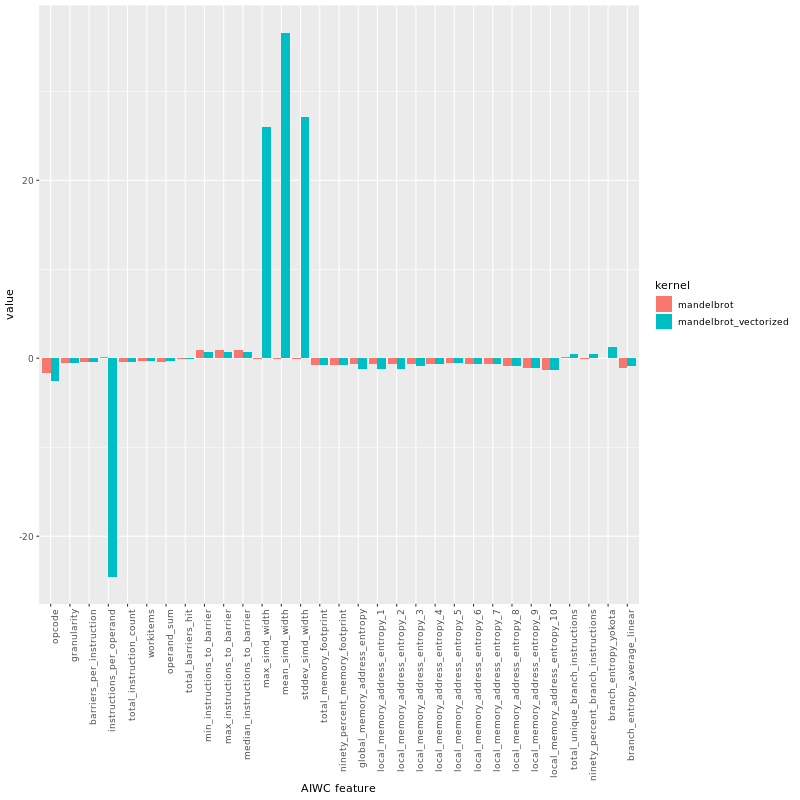

In [116]:
%%R -i aiwc -w 800 -h 800 -u px

library(ggplot2)
library(reshape2)

aiwc.of.interest <- subset(aiwc, application == "mandelbrot_set")
aiwc.of.interest = subset(aiwc.of.interest, select = -size)
aiwc.of.interest = subset(aiwc.of.interest, select = -invocation)
aiwc.of.interest = subset(aiwc.of.interest, select = -application)

melted = melt(aiwc.of.interest, id.var = 'kernel')
ggplot(melted, aes(x = variable, y = value, fill = kernel)) + geom_bar(stat = "identity", position = 'dodge') +
    scale_x_discrete(name = "AIWC feature") + theme(axis.text.x = element_text(angle = 90, hjust = 1))
